In [1]:
from IPython.core.display import HTML
with open ("../../style.css", "r") as file:
    css = file.read()
HTML(css)

# Generating Abstract Syntax Trees

Our grammar is stored in the file `Differentiator.g4`.  The grammar describes arithmetical expression that contain variables.  Furthermore,
the function symbols `ln` (*natural logarithm*) and `exp` (*exponential function*) are supported.

In [3]:
!cat -n Differentiator.g4

     1	grammar Differentiator;
     2	
     3	expr returns [result]
     4	    : e=expr '+' p=product {$result = ('+', $e.result, $p.result)}
     5	    | e=expr '-' p=product {$result = ('-', $e.result, $p.result)}
     6	    | p=product            {$result = $p.result                  }    
     7	    ;
     8	
     9	product returns [result]
    10	    : p=product '*' f=factor {$result = ('*', $p.result, $f.result)}
    11	    | p=product '/' f=factor {$result = ('/', $p.result, $f.result)}
    12	    | f=factor               {$result = $f.result                  }
    13	    ;
    14	
    15	factor returns [result]
    16	    : '(' e=expr ')'       {$result = $e.result;        }
    17	    | 'exp' '(' e=expr ')' {$result = ('exp', $e.result)}
    18	    | 'ln'  '(' e=expr ')' {$result = ('ln' , $e.result)}
    19	    | v=VAR                {$result = $v.text           }
    20	    | n=NUMBER             {$result = int($n.text)      }
    21	    ;
    22	
    23	VAR    : [a-zA-Z][a-

We start by generating both scanner and parser.  

In [4]:
!antlr4 -Dlanguage=Python3 Differentiator.g4

The files `CalculatorLexer.py` and `CalculatorParser.py` contain the generated scanner and parser, respectively.  We have to import these files.  Furthermore, the runtime of 
<span style="font-variant:small-caps;">Antlr</span>
needs to be imported.

In [5]:
from DifferentiatorLexer  import DifferentiatorLexer
from DifferentiatorParser import DifferentiatorParser
import antlr4

In [6]:
%run ../AST-2-Dot.ipynb

The function `main` prompts for an expression that is then parsed and differentiated with respect to the variable `x`. 

In [7]:
def main():
    line = input('> ')
    while line != '':
        input_stream  = antlr4.InputStream(line)
        lexer         = DifferentiatorLexer(input_stream)
        token_stream  = antlr4.CommonTokenStream(lexer)
        parser        = DifferentiatorParser(token_stream)
        context       = parser.expr()
        term          = context.result
        display(tuple2dot(term))
        derivative    = diff(term)
        print(toString(derivative))
        line = input('> ')

The function `diff` takes the parse tree `e` of an arithmetic expression and differentiate this expressions e with respect to the variable `x`. 

In [8]:
def diff(e):
    if isinstance(e, int):
        return '0'
    if e[0] == '+':
        f , g  = e[1:]
        fs, gs = diff(f), diff(g)
        return ('+', fs, gs)
    if e[0] == '-':
        f , g  = e[1:]
        fs, gs = diff(f), diff(g)
        return ('-', fs, gs)
    if e[0] == '*':
        f , g  = e[1:]
        fs, gs = diff(f), diff(g)
        return ('+', ('*', fs, g), ('*', f, gs))
    if e[0] == '/':
        f , g  = e[1:]
        fs, gs = diff(f), diff(g)
        return ('/', ('-', ('*', fs, g), ('*', f, gs)), ('*', g, g))
    if e[0] == 'ln':
        f  = e[1]
        fs = diff(f) 
        return ('/', fs, f)
    if e[0] == 'exp':
        f  = e[1]
        fs = diff(f) 
        return ('*', fs, e)
    if e == 'x':
        return '1'
    return '0'

The function `toString` takes an arithmetical expression that is represented as a nested tuple and converts it into a string.

In [9]:
def toString(e):
    if isinstance(e, int):
        return str(e)
    if e[0] == '+':
        f, g = e[1:]
        return toString(f) + ' + ' + toString(g)
    if e[0] == '-':
        f, g = e[1:]
        return toString(f) + ' - (' + toString(g) + ')'
    if e[0] == '*':
        f, g = e[1:]
        return parenString(f) + ' * ' + parenString(g)
    if e[0] == '/':
        f, g = e[1:]
        return parenString(f) + ' / (' + toString(g) + ')'
    if e[0] == 'ln':
        return 'ln(' + toString(e[1]) + ')'
    if e[0] == 'exp':
        return 'exp(' + toString(e[1]) + ')'
    return str(e)

Convert `e` into a string that is parenthesized if necessary.

In [10]:
def parenString(e):
    if isinstance(e, int):
        return toString(e)
    if e[0] in ['+', '-']:
        return '(' + toString(e) + ')'
    else:
        return toString(e)    

> x * exp(x)


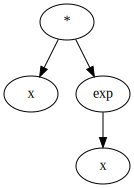

1 * exp(x) + x * 1 * exp(x)
> ln(exp(x))


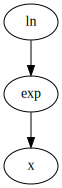

1 * exp(x) / (exp(x))


In [ ]:
main()

In [ ]:
!rm *.py *.tokens *.interp
!rm -r __pycache__/

In [ ]:
!ls